# Web Information Retrieval
## Introduction to search engines

### DAY 2: Teacher version
### Implementing a search engine

The goal of this second session is to implement a first architecture of a search engine on the previously introduced dataset (stackexchange-datascience). If you missed the first session or if you did not saved the dataset, please reload the first session's notebook to download it. 

If you need some ifnormation about the dataset, it should be available here : https://archive.org/details/stackexchange

The notebook is divided into several steps:
-	Implement the indexation
-	Implement the search method
-	Define a ranking strategy and implement it
-	Suggest some improvements of the search engine



## Initialisation

In [1]:
!pip install ttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ttable: filename=ttable-0.6.4-cp310-cp310-linux_x86_64.whl size=212628 sha256=59b5fb8a8dfc396b80f1f158502f3595f0a57759c0e2cc1722af97194c050c06
  Stored in directory: /root/.cache/pip/wheels/0d/8d/56/f2572fdbf1ef1f8a947d7ff25ce18d9373d8e02a68f9ac8de6
Successfully built ttable


In [60]:
import pandas as pd
import re
import os
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from tt import BooleanExpression
from itertools import product
import numpy as np
import string
import matplotlib.pyplot as plt

In [3]:
# Only if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# TODO:
DATA_PATH = '/content/drive/MyDrive/ST_EI/data' 


**Important :**

An Excel file for testing the evaluation part is available in the gitlab repo : evaluation_search_engine_post_queries_ranking_EI_CS.xlsx

If you work on Colab, we advice you to push it directly on your Google Drive directory.

# Implement the indexation
As you might already know, for a search engine to work properly an index of the documents must be created. Here we will keep it in python, and try to use only common libraries to keep it simple.

Once created, the index will be used to match the query with the documents. As a result, there are several ways to build an index, using statistical, boolean, semantic indexation...

First of, let's make a naive one that will consist in breaking down each document into a set of the words it contains.

In [11]:
def extract_words(text:str)->list:
  liste = text.split(' ')
  liste = list(set(liste))
  return liste

In [13]:

# test
s = "The cat is sat on the mat. The dog is laid on the mat."
liste = ["The","cat","is","sat","on","the","mat.","dog","laid"]
liste.sort()
res = extract_words(s)
res.sort()
print(res)
assert res==liste

['The', 'cat', 'dog', 'is', 'laid', 'mat.', 'on', 'sat', 'the']


As you may notice, there are several problems with the previous implementation. First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 

Re-implement this function with some basic preprocessing to avoid these issues.

In [49]:
def extract_words(text:str)->list:
  #enlever les majuscules
  text = text.lower()

  #enlever les ponctuations
  text = text.translate(str.maketrans('', '', string.punctuation))

  liste = text.split(' ')
  liste = list(set(liste))
  if '' in liste :
    liste.remove('')

  return liste

print(extract_words(s))

['on', 'the', 'cat', 'laid', 'is', 'sat', 'dog', 'mat']


In [28]:
# test
assert extract_words(s).sort()==["the","cat","is","sat","on","mat","dog","laid"].sort()

Now you sould be able to create your index table. For now we will just make a dataframe with two columns: [raw_text, words].

In [39]:
import pandas as pd

def index_docs(docs:list[str])->pd.DataFrame:
  # TODO
  dico = {'raw_text':[],'words':[]}
  for elem in docs :
    dico['raw_text'].append(elem)
    dico['words'].append(extract_words(elem))
  print(dico)
  index = [i for i in range (1,len(docs)+1)]
  return pd.DataFrame(dico,index)

In [40]:
# test

L = [s, "Hello World!", "Goodbye", "How are you?"]

index_docs(L)

{'raw_text': ['The cat is sat on the mat. The dog is laid on the mat.', 'Hello World!', 'Goodbye', 'How are you?'], 'words': [['on', 'the', 'cat', 'laid', 'is', 'sat', 'dog', 'mat'], ['hello', 'world'], ['goodbye'], ['how', 'are', 'you']]}


raw_text  \
1  The cat is sat on the mat. The dog is laid on ...   
2                                       Hello World!   
3                                            Goodbye   
4                                       How are you?   

                                     words  
1  [on, the, cat, laid, is, sat, dog, mat]  
2                           [hello, world]  
3                                [goodbye]  
4                          [how, are, you]

Now, let's try it on the dataset:

In [41]:
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts

Id  PostTypeId             CreationDate  Score  ViewCount  \
0           5           1  2014-05-13T23:58:30.457      9      898.0   
1           7           1  2014-05-14T00:11:06.457      4      478.0   
2           9           2  2014-05-14T00:36:31.077      5        NaN   
3          10           2  2014-05-14T00:53:43.273     13        NaN   
4          14           1  2014-05-14T01:25:59.677     26     1901.0   
...       ...         ...                      ...    ...        ...   
75722  119962           1  2023-03-04T20:06:06.820      0        8.0   
75723  119963           1  2023-03-04T20:12:19.677      0       10.0   
75724  119964           1  2023-03-05T00:14:12.597      0        7.0   
75725  119965           1  2023-03-05T00:43:12.213      0        5.0   
75726  119966           1  2023-03-05T03:10:27.593      0        2.0   

                                                    Body  OwnerUserId  \
0      <p>I've always been interested in machine lear...          5.0   
1      <p>As a researcher and instructor, I'm looking...         36.0   
2      <p>Not sure if this fits the scope of this SE,...         51.0   
3      <p>One book that's freely available is "The El...         22.0   
4      <p>I am sure data science as will be discussed...         66.0   
...                                                  ...          ...   
75722  <p>I am implementing a neural network of arbit...     147597.0   
75723  <p>I am using KNN for a regression task</p>\n<...     147598.0   
75724  <p>I have developed a small encoding algorithm...      44581.0   
75725  <p>To my understanding, optimizing a model wit...      84437.0   
75726  <p>I'm working with a dataset of cars, contain...     147605.0   

              LastActivityDate  \
0      2014-05-14T00:36:31.077   
1      2014-05-16T13:45:00.237   
2      2014-05-14T00:36:31.077   
3      2014-05-14T00:53:43.273   
4      2020-08-16T13:01:33.543   
...                        ...   
75722  2023-03-04T20:22:12.523   
75723  2023-03-04T20:12:19.677   
75724  2023-03-05T00:14:12.597   
75725  2023-03-05T00:43:12.213   
75726  2023-03-05T03:10:27.593   

                                                   Title  \
0      How can I do simple machine learning without h...   
1      What open-source books (or other materials) pr...   
2                                                   None   
3                                                   None   
4               Is Data Science the Same as Data Mining?   
...                                                  ...   
75722  Back Propagation on arbitrary depth network wi...   
75723                        Evaluation parameter in knn   
75724  Can I use zero-padded input and output layers ...   
75725  Why does cross validation and hyperparameter t...   
75726                High metrics value (MAE, MSE, RMSE)   

                                                    Tags  ...  \
0                                     <machine-learning>  ...   
1                               <education><open-source>  ...   
2                                                   None  ...   
3                                                   None  ...   
4                             <data-mining><definitions>  ...   
...                                                  ...  ...   
75722                  <neural-network><backpropagation>  ...   
75723                                 <regression><k-nn>  ...   
75724      <deep-learning><convolutional-neural-network>  ...   
75725          <cross-validation><hyperparameter-tuning>  ...   
75726  <python><pandas><machine-learning-model><linea...  ...   

                    ClosedDate  ContentLicense AcceptedAnswerId  \
0      2014-05-14T14:40:25.950    CC BY-SA 3.0              NaN   
1      2014-05-14T08:40:54.950    CC BY-SA 3.0             10.0   
2                         None    CC BY-SA 3.0              NaN   
3                         None    CC BY-SA 3.0              NaN   
4                      

For our first version of the indexation mechanism, we will simply use the "body" of the posts. To have a better search engine, the title and other metadata aswell could be used aswell. Finally, not all the XML files have a "body" feature, so for the search engine to retrieve information from any of the files you will need to implement another way to index.

But first, let's start with "body". There is more to preprocess than before, indeed, there are html tags such as "<p>" for instance. They are not useful for us, because users won't use them in their queries. So we first need to remove them.

In [50]:
def remove_tags(text:str)->str:
  # TODO
  res = text.replace('<p>',' ').replace('\n',' ').strip()
  return res

In [51]:
# test
remove_tags('<p>Hello World!\nI am making a search engine.<p>')

'Hello World! I am making a search engine.'

In [52]:
clean_posts = posts[['Id','Body']]
clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts

<ipython-input-52-2f3e0e9b59ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)


Id                                               Body  \
0           5  <p>I've always been interested in machine lear...   
1           7  <p>As a researcher and instructor, I'm looking...   
2           9  <p>Not sure if this fits the scope of this SE,...   
3          10  <p>One book that's freely available is "The El...   
4          14  <p>I am sure data science as will be discussed...   
...       ...                                                ...   
75722  119962  <p>I am implementing a neural network of arbit...   
75723  119963  <p>I am using KNN for a regression task</p>\n<...   
75724  119964  <p>I have developed a small encoding algorithm...   
75725  119965  <p>To my understanding, optimizing a model wit...   
75726  119966  <p>I'm working with a dataset of cars, contain...   

                                              Clean Body  
0      I've always been interested in machine learnin...  
1      As a researcher and instructor, I'm looking fo...  
2      Not sure if this fits the scope of this SE, bu...  
3      One book that's freely available is "The Eleme...  
4      I am sure data science as will be discussed in...  
...                                                  ...  
75722  I am implementing a neural network of arbitrar...  
75723  I am using KNN for a regression task</p>  It's...  
75724  I have developed a small encoding algorithm th...  
75725  To my understanding, optimizing a model with k...  
75726  I'm working with a dataset of cars, containing...  

[75727 rows x 3 columns]

In [53]:
clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)
clean_posts

<ipython-input-53-921669650514>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)


Id                                               Body  \
0           5  <p>I've always been interested in machine lear...   
1           7  <p>As a researcher and instructor, I'm looking...   
2           9  <p>Not sure if this fits the scope of this SE,...   
3          10  <p>One book that's freely available is "The El...   
4          14  <p>I am sure data science as will be discussed...   
...       ...                                                ...   
75722  119962  <p>I am implementing a neural network of arbit...   
75723  119963  <p>I am using KNN for a regression task</p>\n<...   
75724  119964  <p>I have developed a small encoding algorithm...   
75725  119965  <p>To my understanding, optimizing a model wit...   
75726  119966  <p>I'm working with a dataset of cars, contain...   

                                              Clean Body  \
0      I've always been interested in machine learnin...   
1      As a researcher and instructor, I'm looking fo...   
2      Not sure if this fits the scope of this SE, bu...   
3      One book that's freely available is "The Eleme...   
4      I am sure data science as will be discussed in...   
...                                                  ...   
75722  I am implementing a neural network of arbitrar...   
75723  I am using KNN for a regression task</p>  It's...   
75724  I have developed a small encoding algorithm th...   
75725  To my understanding, optimizing a model with k...   
75726  I'm working with a dataset of cars, containing...   

                                                   words  
0      [i, hard, the, move, hardcoding, simple, whole...  
1      [relatively, materials, researcher, science, s...  
2      [have, ai, the, fixed, within, for, flexible, ...  
3      [than, friedman, ng, does, on, the, behind, ma...  
4      [at, class, i, am, science, will, regards, min...  
...                                                  ...  
75722  [codepre, thus, i, am, forwards, having, on, m...  
75723  [have, i, better, question, the, result, dot, ...  
75724  [have, i, done, points, the, samples, so, look...  
75725  [have, i, basically, the, result, for, used, t...  
75726  [modelyear, i, rows, the, 1720953, determinati...  

[75727 rows x 4 columns]

## Inverted Index

Now, we want to go further on the indexing and build an inverted index. Inverted index is a dictionary where the keys are the words of the vocabulary and the values are the documents containing these words. Reducing the size of the vocabulary is a relevant first step when building an inverted index. Here, we will focus on the creation of the index, we leave you the optimisation steps :)

In [54]:
def create_index(posts:pd.DataFrame)-> dict:
  # TODO
  dico = {}
  for i in posts.index:
    liste = posts['words'][i]
    for elem in liste :
      if elem in dico:
        dico[elem].append(posts['Id'][i])
      else :
        dico[elem] = [posts['Id'][i]]
  
  return dico

In [56]:
inverted_index = create_index(clean_posts.iloc[0:5000])
inverted_index

{'i': [5,
  14,
  16,
  24,
  29,
  31,
  35,
  38,
  40,
  43,
  50,
  51,
  52,
  59,
  69,
  72,
  76,
  78,
  83,
  85,
  87,
  89,
  91,
  96,
  97,
  101,
  106,
  107,
  111,
  112,
  113,
  115,
  116,
  121,
  125,
  133,
  134,
  135,
  143,
  153,
  155,
  157,
  159,
  160,
  161,
  163,
  164,
  165,
  169,
  172,
  175,
  176,
  183,
  184,
  189,
  190,
  191,
  194,
  195,
  196,
  197,
  204,
  208,
  209,
  211,
  212,
  215,
  216,
  218,
  220,
  222,
  224,
  227,
  228,
  231,
  236,
  237,
  238,
  242,
  243,
  244,
  245,
  248,
  249,
  251,
  253,
  254,
  256,
  258,
  259,
  263,
  265,
  268,
  269,
  272,
  274,
  277,
  278,
  280,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  298,
  302,
  303,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  319,
  320,
  324,
  325,
  326,
  327,
  328,
  331,
  332,
  334,
  335,
  336,
  337,
  338,
  339,
  346,
  348,
  349,
  351,
  352,
  354,
  355,
  356,
  357,
  365,

## Zipf Law

A way of analyzing a corpus is to draw the zipf law

[('a', 4467), ('the', 4422), ('to', 4214), ('and', 3939), ('of', 3931), ('is', 3828), ('in', 3625), ('for', 3397), ('i', 3095), ('that', 2928), ('this', 2658), ('it', 2648), ('you', 2622), ('are', 2572), ('with', 2510), ('be', 2436), ('on', 2425), ('data', 2394), ('can', 2361), ('have', 2325), ('as', 2266), ('or', 2084), ('if', 2038), ('but', 2008), ('not', 1876), ('p', 1860), ('from', 1656), ('an', 1623), ('which', 1607), ('use', 1580), ('would', 1541), ('there', 1541), ('so', 1508), ('your', 1494), ('some', 1494), ('what', 1425), ('by', 1403), ('like', 1377), ('one', 1339), ('do', 1320), ('using', 1309), ('more', 1306), ('how', 1242), ('will', 1222), ('at', 1172), ('all', 1112), ('my', 1103), ('also', 1061), ('each', 1056), ('any', 1046), ('other', 1027), ('then', 1022), ('about', 990), ('want', 944), ('has', 942), ('example', 905), ('should', 853), ('its', 847), ('set', 833), ('model', 831), ('learning', 826), ('am', 826), ('get', 819), ('could', 818), ('into', 809), ('just', 796), 

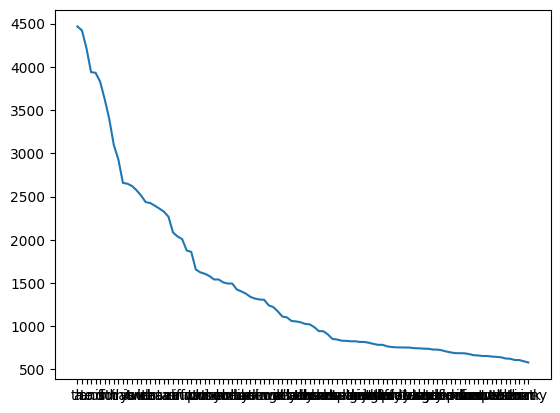

In [63]:
# TODO : Draw Zipf Law on the Posts Corpus
zipf = []
for key in inverted_index.keys():
  zipf.append((key,len(inverted_index[key])))

zipf.sort(key = lambda x : x[1], reverse=True)
print(zipf)

X = [zipf[i][0] for i in range(100)]
Y = [zipf[i][1] for i in range(100)]

plt.plot(X,Y)
plt.show()



#### Well Done, you've indexed the dataset! 
Don't hesitate to save your indexes in txt or pickle file

---
# Implement the search method

A naive method would be to count the number of words in common between the query and each posts. Then to rank the posts you could directly select the post who maximize the number of common words. Let's implement this approach :

In [64]:
# Implement the word_in_index function 
# Inputs : a word (str) & a list of words
# Output : pandas series of 1 if the word is in the list, else 0

def word_in_index(word, word_list_index):
  if word in word_list_index:
    res = pd.Series([1])
  else :
    res = pd.Series([0])
  return res

In [73]:
word_in_index('test',['word'])

0    0
dtype: int64

In [81]:
# Implement the function which run through a pandas series and count the number of word in common
# Use extract_words method, apply method with word_in_index function
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query, word_serie):
  # TODO
  res = pd.Series([0])
  requete = extract_words(query)
  for word in requete:
    res = res.add(word_in_index(word,word_serie))
  return res


In [82]:
count_common_words('test the query',['test','mot','word','the'])

0    2
dtype: int64

In [101]:

def rank_top_query(query, df, top=5):
  # TODO
  nb_of_common_words = pd.Series([])
  for i in df.index:
    nb_of_common_words = pd.concat([nb_of_common_words,count_common_words(query,df['words'][i])], ignore_index = True)
  df['Common words with query'] = nb_of_common_words
  newdf = df.sort_values(by='Common words with query', ascending = False)
  res = newdf.head(top)
  return res

In [103]:
rank_top_query(query="testing the query in python", df=clean_posts, top=5)

<ipython-input-101-22dee85d46cb>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nb_of_common_words = pd.Series([])
<ipython-input-101-22dee85d46cb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Common words with query'] = nb_of_common_words


Id                                               Body  \
273       309  <p><strong>tl;dr:</strong> They markedly diffe...   
6797    12313  <p>While the actual "best system" depends heav...   
74072  117083  <p>To implement this correctly you need to und...   
5537    10695  <p>I am using Gensim Library in python for usi...   
10447   17212  <p>R and SQL are two completely different beas...   

                                              Clean Body  \
273    <strong>tl;dr:</strong> They markedly differ i...   
6797   While the actual "best system" depends heavily...   
74072  To implement this correctly you need to unders...   
5537   I am using Gensim Library in python for using ...   
10447  R and SQL are two completely different beasts....   

                                                   words  \
273    [than, done, i, our, have, surrounding, lot, r...   
6797   [representation, correspond, noting, understan...   
74072  [did, watch, reading, remaining, hrefhttpsscik...   
5537   [helpp, have, i, the, for, precoderesetfromoth...   
10447  [i, recording, syntax, the, alternative, compl...   

       Common words with query  
273                          5  
6797                         4  
74072                        4  
5537                         4  
10447                        4

Testez plusieurs requêtes et critiquez les résultats obtenus.

Quels sont les pros and cons de cette méthodes. Vous l'indiquerez sur le rapport avec vos réflexions pour l'améliorer.

Next, you have to implement the first improvements you find in the search method to get most relevant results 

In [105]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
liste_stop_words = stopwords.words('english')
print(liste_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:

def remove_stop_words(l_txt: list) -> list:
  newlist = []
  for word in l_txt:
    if word not in liste_stop_words:
      newlist.append(word)

  return newlist

In [107]:
s = "The cat is sat on the mat. The dog is laid on the mat."
l = extract_words(s)
print(l)
print(remove_stop_words(l))

['on', 'the', 'cat', 'laid', 'is', 'sat', 'dog', 'mat']
['cat', 'laid', 'sat', 'dog', 'mat']


## Boolean Search

Thanks to the ttable library, implement a boolean search method

In [110]:
from tt import BooleanExpression, TruthTable

In [130]:
def boolean_search(query,df):
  # TODO
  requete = BooleanExpression(query)
  symbolsreq = requete.symbols
  t = TruthTable(requete)
  docs_ids = []
  for i in df.index :
    listereq = []
    for s in symbolsreq : 
      if s in df['words'][i]:
        listereq.append(1)
      else : 
        listereq.append(0)

    ligneeval = ''
    for nb in listereq:
      ligneeval+=str(nb)
    tableindex = int(ligneeval,2)

    if t[tableindex]:
      docs_ids.append(df['Id'][i])

  return docs_ids

In [113]:
print(boolean_search('test and not query'))

+------+-------+---+
| test | query |   |
+------+-------+---+
|  0   |   0   | 0 |
+------+-------+---+
|  0   |   1   | 0 |
+------+-------+---+
|  1   |   0   | 1 |
+------+-------+---+
|  1   |   1   | 0 |
+------+-------+---+


In [131]:
print(boolean_search('done and have and surrounding and lot',clean_posts.iloc[0:500] ))

[309]


## Probabilistic search

Implement the MIB or BM25 method of searching

In [ ]:
def probabilistic_search(query):
  # TODO

  return

Compare the naive method with your improvements and the boolean and probabilistic search. (report)



---



---




# Evaluate the Search

Now you implement multiple search methods and you're able to improve it. You have to define metric to compare it objectively.



We ask you to implement NDCG (Normalized Discounted Cumulative Gain) from few queries we implement on a dozen of post. We already defined the values of relevance judgement in the xlsx file : . The final score will be the mean quadratic error of the queries.


Explication for the xlsx file :

We propose you a Excel file with some posts and a mesure of relevancy for the queries

- First column is the post Id,
- Columns starting by query are the queries you have to test.
- The values in this columns are the rank of relevancy of the post in regard with the query.
- The missing values indicates you should not take into account the post


You will have to criticize this metric and your result in the report. Then you will have to propose some improvements. 

Thereafter in this week, you will have to compare your different search engines.

In [ ]:
# Read Relevancy CSV
df_relevancy = pd.read_excel("/content/drive/MyDrive/TP Centrale/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")

In [ ]:
def calculate_ndgc(query_col="query", output_col="query_output"):
  # TODO

  return

